In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [52]:
df = pd.read_csv('dummy_dataset.csv')

In [53]:
df.columns = df.columns.str.strip()

In [54]:
df['jam_estimasi_habis'] = pd.to_datetime(df['jam_estimasi_habis'], format='%H:%M', errors='coerce').dt.time
df.dropna(subset=['jam_estimasi_habis'], inplace=True)

***Feature Engineering***

In [55]:
konsumsi_map = df.groupby(['seksi_tujuan', 'nama_komponen'])['konsumsi_per_jam'].mean().to_dict()

In [56]:
joblib.dump(konsumsi_map, 'konsumsi_map.pkl')

['konsumsi_map.pkl']

In [57]:
df['waktu_habis_stok'] = df['stok_tersedia'] / df['konsumsi_per_jam']

In [58]:
def tentukan_status(row):
    waktu_habis = row['waktu_habis_stok']
    lead_time = row['lead_time']
    
    # Rule 1: If material has arrived, it's always safe (Green)
    if row['status_pengiriman'] == 'Sudah Tiba':
        return 'Hijau'
    
    # Rule 2 (CRITICAL): Stock runs out before or exactly when material arrives -> RED
    if waktu_habis <= lead_time:
        return 'Merah'
    
    # Rule 3 (WARNING): There's a buffer, but it's risky (e.g., less than 50% buffer) -> YELLOW
    if lead_time < waktu_habis <= lead_time * 1.5:
        return 'Kuning'
    
    # Rule 4 (SAFE): Sufficient buffer -> GREEN
    return 'Hijau'

In [59]:
df['warna_status_revised'] = df.apply(tentukan_status, axis=1)

In [60]:
df.dropna(subset=['waktu_habis_stok', 'lead_time'], inplace=True)

In [61]:
df.to_csv('data_preprocessed.csv', index=False)

***Model Preparation***

In [62]:
features = ['seksi_tujuan', 'nama_komponen', 'stok_tersedia', 'lead_time']
target = 'warna_status_revised'

In [63]:
X = df[features]
y = df[target]

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [65]:
numeric_features = ['stok_tersedia', 'lead_time']
categorical_features = ['seksi_tujuan', 'nama_komponen']

In [66]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

***Modeling & Evaluation***

In [67]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

In [68]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['stok_tersedia',
                                                   'lead_time']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['seksi_tujuan',
                                                   'nama_komponen'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [69]:
y_pred = model_pipeline.predict(X_test)

In [70]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\n=> Akurasi Model pada Data Test: {accuracy:.2%}")


=> Akurasi Model pada Data Test: 100.00%


In [71]:
print("\nLaporan Klasifikasi Lengkap:")
print(classification_report(y_test, y_pred, target_names=['Hijau', 'Kuning', 'Merah']))


Laporan Klasifikasi Lengkap:
              precision    recall  f1-score   support

       Hijau       1.00      1.00      1.00        76
      Kuning       1.00      1.00      1.00         8
       Merah       1.00      1.00      1.00         3

    accuracy                           1.00        87
   macro avg       1.00      1.00      1.00        87
weighted avg       1.00      1.00      1.00        87




Confusion Matrix:


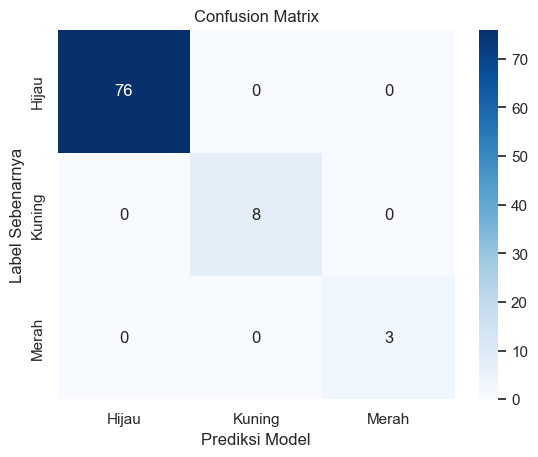

In [72]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=['Hijau', 'Kuning', 'Merah'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Hijau', 'Kuning', 'Merah'], yticklabels=['Hijau', 'Kuning', 'Merah'])
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix')
plt.show()

In [73]:
joblib.dump(model_pipeline, 'model_pipeline.pkl')

['model_pipeline.pkl']